# Introduction

The West Nile Virus (WNV) has been a serious problem for the United States since 1999. The [CDC](https://www.cdc.gov/westnile/index.html) has acknowledged it as the leading cause of mosquito-borne disease in the continental United States. However, there are no vaccines to prevent or medications to treat WNV in people -- according to the CDC, 1 in 5 people who are infected develop a fever and other symptoms, while 1 out of 150 infected people develop a serious, sometimes fatal, illness.

In Illinois, [West Nile virus was first identified in September 2001](https://www.dph.illinois.gov/topics-services/diseases-and-conditions/west-nile-virus) when laboratory tests confirmed its presence in two dead crows found in the Chicago area. The following year, the state's first human cases and deaths from West Nile disease were recorded and all but two of the state's 102 counties eventually reported a positive human, bird, mosquito or horse. By the end of 2002, Illinois had counted more human cases (884) and deaths (64) than any other state in the United States.

Since then, Illinois and more specifically Chicago, has continued to suffer from multiple outbreaks of the West Nile Virus. From 2005 to 2016, a total of 1,371 human WNV cases were [reported](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0227160) within Illinois. Out of these total reported cases, 906 cases (66%) were from the Chicago region (Cook and DuPage Counties). 

With this in mind, <b>our project is aimed at predicting outbreaks of the West Nile Virus</b>. This will help the City of Chicago and Chicago Department of Public Health (CDPH) more efficiently and effectively allocate resources towards preventing transmission of this potentially deadly virus. Specifically, our model will use a combination of weather, time and location features to predict the presence of WNV within mosquito traps set up throughout Chicago. 

Our project also aims to determine the best strategy for controlling the spread of the West Nile Virus, as well as discussing and justifying the various trade-offs that need to be made in implementing our model.

# Data Cleaning

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Load datasets
train = pd.read_csv('./datasets/train.csv')
test = pd.read_csv('./datasets/test.csv')
weather = pd.read_csv('./datasets/weather.csv')
spray = pd.read_csv('./datasets/spray.csv')

### Summary of Changes

Weather:

- Imputed missing values for daily average temperature `Tavg` with average of `Tmax` and `Tmin`
- Calculated missing values for `Cool` and `Warm` with `Tavg`
- Calculated missing `Depart` from Station 2 with 30 year normal temperature based on Station 1 readings and Station 2 `Tavg`.
- Imputed missing values for `WetBulb`, `PrecipTotal`, `StnPressure`, `SeaLevel`, `AvgSpeed` using readings of Station with non-missing value.
- Imputed 'T' or trace values as 0.01.
- Imputed `Sunrise` and `Sunset` for Station 2 with Station 1 values
- Split and recombined `CodeSum` to create proper spacing between different codes
- Created new feature counting number of exceptional weather phenomena based on `CodeSum`
- Created more interpretable features like `rain` and `lowvis` based on `CodeSum`
- Changed `Date` from string object to `datetime64`
- Dropped `Water1`, `Depth`, `SnowFall` due to high missing values (>99.5% 'M' or 0)
- Transformed all features into float values
- Merged Station 1 and Station 2 by averaging values of each station
- Added Year, Month, Week and Day of Week features

Train / Test:
- Added Year, Month, Week and Day of Week features

Spray:
- Dropped duplicates
- Dropped missing `Time` values

## Weather

### Initial Analysis

In [ ]:
weather.head()

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,...,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,0,3,...,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,...,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52,M,42,47,13,0,...,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,...,,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9


In [ ]:
# Checking for missing values
weather.isnull().sum()[weather.isnull().sum() > 0]

Series([], dtype: int64)

In [ ]:
# Checking for duplicate values
weather.duplicated().sum()[weather.duplicated().sum() > 0]

array([], dtype=int64)

In [ ]:
# Many 'M' or missing values in certain columns
weather.isin(['M']).sum()[weather.isin(['M']).sum() > 0].sort_values(ascending=False)

Water1         2944
SnowFall       1472
Depth          1472
Depart         1472
Cool             11
Heat             11
Tavg             11
SeaLevel          9
StnPressure       4
WetBulb           4
AvgSpeed          3
PrecipTotal       2
dtype: int64

In [ ]:
# Some 'T' or trace values
weather.isin(['  T']).sum()[weather.isin(['  T']).sum() > 0]

SnowFall        12
PrecipTotal    318
dtype: int64

In [ ]:
# Checking for zero values
weather.isin(['0.0']).sum()[weather.isin(['0.0']).sum() > 0]

SnowFall    1459
dtype: int64

In [ ]:
# Checking for zero values
weather.isin(['0']).sum()[weather.isin(['0']).sum() > 0]

Heat     1870
Depth    1472
dtype: int64

### Imputing / Dropping Features

In [ ]:
# Drop columns due to high missing values (>99.5% 'M' or 0)
weather = weather.drop(columns=['Water1', 'Depth', 'SnowFall'])

In [ ]:
# Function to impute Average Temperature, Cooling and Heating Degrees
def impute_tavg_heat_cool(row):
    # Impute missing values for Tavg
    if row['Tavg'] == 'M':
        row['Tavg'] = round((row['Tmax'] + row['Tmin']) / 2)
        
    # Impute missing values for Cool and Warm
    if row['Cool'] == 'M' or row['Heat'] == 'M':
        hd = 65 - row['Tavg']
        if hd < 0: 
            row['Cool'] = hd
            row['Heat'] = 0
        elif hd > 0:
            row['Cool'] = 0
            row['Heat'] = hd
        else:
            row['Cool'] = row['Heat'] = 0
    return row

In [ ]:
weather = weather.apply(impute_tavg_heat_cool, axis=1)

In [ ]:
# Function to extract 30 year normal temperature from station 1's readings
def create_normal(row):
    if row['Station'] == 1:
        row['Normal'] = int(row['Tavg']) - int(row['Depart'])
    return row

# Apply 30 year temperature to station 2's readings 
def apply_normal(row):
    if row['Station'] == 2:
        row['Normal'] = weather[(weather['Date'] == row['Date']) & (weather['Station'] == 1)]['Normal'].values[0]
    return row

In [ ]:
weather = weather.apply(create_normal, axis=1)
weather = weather.apply(apply_normal, axis=1)

In [ ]:
# Rearrange columns
weather = weather[['Station', 'Date', 'Tmax', 'Tmin', 'Tavg', 'Normal', 'Depart', 'DewPoint',
       'WetBulb', 'Heat', 'Cool', 'Sunrise', 'Sunset', 'CodeSum',
       'PrecipTotal', 'StnPressure', 'SeaLevel', 'ResultSpeed', 'ResultDir',
       'AvgSpeed']]

In [ ]:
# Remaining 'M' values
weather.isin(['M']).sum()[weather.isin(['M']).sum() > 0]

Depart         1472
WetBulb           4
PrecipTotal       2
StnPressure       4
SeaLevel          9
AvgSpeed          3
dtype: int64

In [ ]:
# Impute remaining Depart, WetBulb, PrecipTotal, StnPressure, SeaLevel, AvgSpeed
def impute_remaining(row):
    replace_dict = {}
    for index in row.index:
        if row[index] == 'M':
            replace_dict[index] = 'M'
    if replace_dict:
        if 'Depart' in replace_dict:
            row['Depart'] = int(row['Tavg']) - int(row['Normal'])
            del replace_dict['Depart']
            
        for key, value in replace_dict.items():
            # Retrieve from Station 1 if Station 2 is 'M' and vice versa
            if row['Station'] == 2:
                row[key] = weather[(weather['Date'] == row['Date']) & (weather['Station'] == 1)][key].values[0]
            else:
                row[key] = weather[(weather['Date'] == row['Date']) & (weather['Station'] == 2)][key].values[0]
                
    return row

In [ ]:
weather = weather.apply(impute_remaining, axis=1)

In [ ]:
# Function above didn't work as both station 1 and 2 have a missing value for StnPressure
weather[weather['StnPressure'] == 'M']

,Station,Date,Tmax,Tmin,Tavg,Normal,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
2410,1,2013-08-10,81,64,73,73.0,0,57,63,0,8,0454,1900,,0.00,M,30.08,5.3,5,6.5
2411,2,2013-08-10,81,68,75,73.0,2,55,63,0,10,-,-,,0.00,M,30.07,6.0,6,7.4


In [ ]:
# Impute according to the StnPressure of the day after
weather.at[2410, 'StnPressure'] = weather[weather['Date'] == '2013-08-11']['StnPressure'].values[0]
weather.at[2411, 'StnPressure'] = weather[weather['Date'] == '2013-08-11']['StnPressure'].values[1]

In [ ]:
# Changing trace to 0.01
weather['PrecipTotal'] = weather['PrecipTotal'].apply(lambda x: 0.01 if 'T' in x else x)

In [ ]:
# Change Date column from string to datetime
weather['Date'] = pd.to_datetime(weather['Date'])

In [ ]:
# Impute sunrise/sunset
def impute_sun(row):
    if row['Station'] == 2:
        row['Sunrise'] = weather[(weather['Date'] == row['Date']) & (weather['Station'] == 1)]['Sunrise'].values[0]
        row['Sunset'] = weather[(weather['Date'] == row['Date']) & (weather['Station'] == 1)]['Sunset'].values[0]
    return row

In [ ]:
weather = weather.apply(impute_sun, axis=1)

The `CodeSum` feature is slightly tricky to deal with -- there's a variety of ways we could take this forward, including one-hot encoding of each weather code. However, a number of codes are extremely rare or don't exist within our data. We're dealing with this by combining weather codes into several features that include snow, rain, windy or low visibility (fog/mist) conditions. 

In [ ]:
# Ensuring that each code has proper spacing
codes = ['+FC','FC', 'TS', 'GR', 'RA', 'DZ', 'SN', 'SG', 'GS', 'PL',
         'IC', 'FG+', 'FG', 'BR', 'UP', 'HZ', 'FU', 'VA', 'DU', 'DS',
         'PO', 'SA', 'SS', 'PY', 'SQ', 'DR', 'SH', 'FZ', 'MI', 'PR',
         'BC', 'BL', 'VC']
weather['CodeSum'] = weather['CodeSum'].apply(lambda x: ' '.join([t for t in x.split(' ') if t in codes]))

We'll also look to create a feature measuring the number of significant weather phenomena within a single day. There's a chance that these weather events could have some kind of association with our target variable.

In [ ]:
weather['n_codesum'] = weather['CodeSum'].apply(lambda x: len(x.split()))

In [ ]:
snow = ['SN', 'SG', 'GS', 'PL', 'IC', 'DR', 'BC']
windy = ['SQ', 'DS', 'SS', 'PO', 'BL']
rain = ['TS', 'GR', 'RA', 'DZ', 'SH']
lowvis = ['FG+', 'FG', 'BR', 'HZ']
codesum_others = ['UP', 'VA', 'DU', 'SA', 'FZ']

In [ ]:
def codesum_split(row):
    codes = row['CodeSum'].split()
    
    # Check for weather conditions
    if any(code in codes for code in snow):
        row['snow'] = 1
    if any(code in codes for code in windy):
        row['windy'] = 1 
    if any(code in codes for code in rain):
        row['rain'] = 1 
    if any(code in codes for code in lowvis):
        row['lowvis'] = 1
    if any(code in codes for code in codesum_others):
        row['codesum_others'] = 1
        
    return row

In [ ]:
weather = weather.apply(codesum_split, axis=1)

In [ ]:
weather = weather.fillna(0)

In [ ]:
weather[['snow', 'windy', 'rain', 'lowvis']].sum()

snow         6.0
windy        3.0
rain      1007.0
lowvis     882.0
dtype: float64

In [ ]:
# Dropping snow & windy due to extremely low variance
weather = weather.drop(columns=['snow', 'windy'])

In [ ]:
# Convert remaining columns
for col in weather.columns:
    try:
        weather[col] = weather[col].astype(float)
    except:
        print(col, 'cannot be transformed into float')
        pass

CodeSum cannot be transformed into float
Date cannot be transformed into float


### Merging Station 1 and Station 2 

In [ ]:
weather = weather.groupby('Date').sum() / 2
weather = weather.drop(columns=['Station']).reset_index()

In [ ]:
weather = weather.drop(columns='Normal')

In [ ]:
weather

,Date,AvgSpeed,Cool,Depart,DewPoint,Heat,PrecipTotal,ResultDir,ResultSpeed,SeaLevel,StnPressure,Sunrise,Sunset,Tavg,Tmax,Tmin,WetBulb,lowvis,n_codesum,rain
0,2007-05-01,9.40,2.5,14.5,51.0,0.0,0.000,26.0,2.20,29.820,29.140,448.0,1849.0,67.5,83.5,51.0,56.5,0.0,0.0,0.0
1,2007-05-02,13.40,0.0,-2.5,42.0,13.5,0.000,3.0,13.15,30.085,29.410,447.0,1850.0,51.5,59.5,42.5,47.0,1.0,1.5,0.0
2,2007-05-03,12.55,0.0,3.0,40.0,8.0,0.000,6.5,12.30,30.120,29.425,446.0,1851.0,57.0,66.5,47.0,49.0,0.5,0.5,0.0
3,2007-05-04,10.60,0.0,7.0,41.5,4.0,0.005,7.5,10.25,30.045,29.335,444.0,1852.0,61.0,72.0,50.0,50.0,0.0,0.5,0.5
4,2007-05-05,11.75,0.0,5.0,38.5,5.0,0.010,7.0,11.45,30.095,29.430,443.0,1853.0,60.0,66.0,53.5,49.5,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1467,2014-10-27,13.25,1.0,17.5,51.5,0.5,0.010,19.0,12.35,29.665,28.960,618.0,1653.0,65.5,78.0,52.5,58.5,0.0,0.5,0.5
1468,2014-10-28,15.10,0.0,10.0,39.0,8.0,0.020,26.0,14.40,29.850,29.190,619.0,1651.0,57.0,67.0,46.5,47.5,0.0,0.5,0.5
1469,2014-10-29,9.45,0.0,-3.0,33.0,21.0,0.000,29.0,9.00,30.065,29.390,620.0,1650.0,44.0,49.0,38.0,41.0,0.0,0.0,0.0
1470,2014-10-30,6.00,0.0,-2.5,34.5,21.5,0.005,23.5,5.50,30.095,29.375,622.0,1649.0,43.5,52.0,34.5,41.0,0.0,0.5,0.5


In [ ]:
# Add Year, Month, Week and Day of Week features
weather['Date'] = pd.to_datetime(weather['Date'])
weather['Year'] = weather['Date'].apply(lambda x: x.year)
weather['Month'] = weather['Date'].apply(lambda x: x.month)
weather['Week'] = weather['Date'].apply(lambda x: x.week)
weather['DayOfWeek'] = weather['Date'].apply(lambda x: x.dayofweek)

In [ ]:
weather.to_csv('./datasets/cleaned_weather.csv', index=False)

# Train

In [ ]:
# Add Year, Month, Week and Day of Week features
train['Date'] = pd.to_datetime(train['Date'])
train['Year'] = train['Date'].apply(lambda x: x.year)
train['Month'] = train['Date'].apply(lambda x: x.month)
train['Week'] = train['Date'].apply(lambda x: x.week)
train['DayOfWeek'] = train['Date'].apply(lambda x: x.dayofweek)

In [ ]:
train['WnvPresent'] = train['WnvPresent'].map(lambda x : 1 if x > 0 else x)

train.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,Year,Month,Week,DayOfWeek
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0,2007,5,22,1
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0,2007,5,22,1
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0,2007,5,22,1
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0,2007,5,22,1
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0,2007,5,22,1


In [ ]:
train.to_csv('./datasets/cleaned_train.csv', index=False)

# Test

In [ ]:
# Add Year, Month, Week and Day of Week features
test['Date'] = pd.to_datetime(test['Date'])
test['Year'] = test['Date'].apply(lambda x: x.year)
test['Month'] = test['Date'].apply(lambda x: x.month)
test['Week'] = test['Date'].apply(lambda x: x.week)
test['DayOfWeek'] = test['Date'].apply(lambda x: x.dayofweek)

In [ ]:
test.to_csv('./datasets/test.csv', index=False)

# Spray

In [ ]:
spray.dtypes

Date          object
Time          object
Latitude     float64
Longitude    float64
dtype: object

In [ ]:
spray.describe()

,Latitude,Longitude
count,14835.000000,14835.000000
mean,41.904828,-87.736690
std,0.104381,0.067292
min,41.713925,-88.096468
25%,41.785001,-87.794225
50%,41.940075,-87.727853
75%,41.980978,-87.694108
max,42.395983,-87.586727


In [ ]:
spray.isnull().sum()

Date           0
Time         584
Latitude       0
Longitude      0
dtype: int64

In [ ]:
spray.loc[spray.Time.isnull()]

,Date,Time,Latitude,Longitude
1030,2011-09-07,NaN,41.987092,-87.794286
1031,2011-09-07,NaN,41.987620,-87.794382
1032,2011-09-07,NaN,41.988004,-87.794574
1033,2011-09-07,NaN,41.988292,-87.795486
1034,2011-09-07,NaN,41.988100,-87.796014
...,...,...,...,...
1609,2011-09-07,NaN,41.995876,-87.811615
1610,2011-09-07,NaN,41.995972,-87.810271
1611,2011-09-07,NaN,41.995684,-87.810319
1612,2011-09-07,NaN,41.994724,-87.810415


In [ ]:
spray.Time.value_counts().head()

7:44:32 PM    541
8:55:36 PM      5
8:57:46 PM      5
9:05:56 PM      5
8:58:56 PM      5
Name: Time, dtype: int64

In [ ]:
spray.loc[spray.Time == "7:44:32 PM"]

,Date,Time,Latitude,Longitude
489,2011-09-07,7:44:32 PM,41.98646,-87.794225
490,2011-09-07,7:44:32 PM,41.98646,-87.794225
491,2011-09-07,7:44:32 PM,41.98646,-87.794225
492,2011-09-07,7:44:32 PM,41.98646,-87.794225
493,2011-09-07,7:44:32 PM,41.98646,-87.794225
...,...,...,...,...
1025,2011-09-07,7:44:32 PM,41.98646,-87.794225
1026,2011-09-07,7:44:32 PM,41.98646,-87.794225
1027,2011-09-07,7:44:32 PM,41.98646,-87.794225
1028,2011-09-07,7:44:32 PM,41.98646,-87.794225


In [ ]:
spray.loc[spray.Time == "8:55:46 PM"]

,Date,Time,Latitude,Longitude
1977,2011-09-07,8:55:46 PM,41.976100,-87.816673
4430,2013-07-25,8:55:46 PM,41.951602,-87.737952
5671,2013-07-25,8:55:46 PM,41.963285,-87.731448
8339,2013-08-15,8:55:46 PM,41.900962,-87.766902
13746,2013-08-29,8:55:46 PM,41.984972,-87.682210


In [ ]:
spray.loc[spray.Time == "8:59:06 PM"]

,Date,Time,Latitude,Longitude
1989,2011-09-07,8:59:06 PM,41.975935,-87.814502
4446,2013-07-25,8:59:06 PM,41.952915,-87.736862
5685,2013-07-25,8:59:06 PM,41.965852,-87.729210
8356,2013-08-15,8:59:06 PM,41.907507,-87.767123
13765,2013-08-29,8:59:06 PM,41.984953,-87.681537


In [ ]:
spray.loc[spray.Time == "9:37:27 PM"]

,Date,Time,Latitude,Longitude
3012,2013-07-17,9:37:27 PM,41.721428,-87.646542
3562,2013-07-17,9:37:27 PM,41.732493,-87.638753
5844,2013-07-25,9:37:27 PM,41.959863,-87.726518
6266,2013-08-08,9:37:27 PM,41.922618,-87.685417
11787,2013-08-29,9:37:27 PM,41.785288,-87.700895


In [ ]:
spray.loc[spray.Time == "9:31:27 PM"]

,Date,Time,Latitude,Longitude
2993,2013-07-17,9:31:27 PM,41.729072,-87.650778
3533,2013-07-17,9:31:27 PM,41.731983,-87.651698
5818,2013-07-25,9:31:27 PM,41.957613,-87.724063
6244,2013-08-08,9:31:27 PM,41.922953,-87.680385
11756,2013-08-29,9:31:27 PM,41.783147,-87.698363


We can immediately see that there are some duplicates within the datasets. So let's remove them.

In [ ]:
#dropping the duplicates
spray.drop_duplicates(inplace=True)

Since we could not find a pattern to impute the null values, we have decided to drop the feature.

In [ ]:
spray.drop(columns='Time',inplace=True)

/opt/venv/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


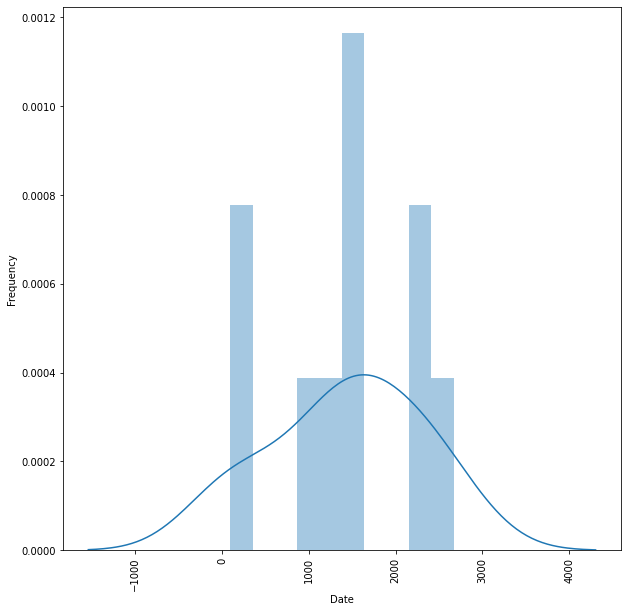

In [ ]:
plt.figure(figsize=(10,10))
sns.distplot(spray.Date.value_counts(), bins=10)
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show();